In [ ]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


- 1. [Introduction](#section_intro) 
    - 1.1. [Overview](#)
    - 1.2. [Pre-request](#)
- 2. [Understanding Data](#)
    - 2.1. [Simple Statistics with training data](#)
    - 2.2. [Simple Statistics with testing data](#)
- 3. [Data Visualization](#) 
- 4. [Data Preprocessing](#) 
    - 4.1. [Handling Missing Values](#section_missingvalues) 
    - 4.2. [Handling Categorical data](#section_categoricalData) 
    - 4.3. [Handle imbalance dataset](#section_imbalance) 
    - 4.4. [Feature Reduction (next submission)](#) 
    - 4.5. [Scaling](#section_scaling)
- 5. [Feature Engineering](#section_feature)
- 6. [Model](#section_model) 
    - 6.1. [Base model without hyperparameter tuning ](#section_wo_hyper) 
        - 6.1.1. [XGBoost](#section_xgboost) 
        - 6.1.2. [Logistic Regression](#section_log_reg) 
    - 6.2. [Model with hyperparameter tuning using optuna](#section_hyper) 
        - 6.2.1. [XGBoost](#section_xgb_hyper) 
- 7. [Submision](#section_sub)

<a id="section_intro"></a>
# 1. Introduction

<a id="section_intro"></a>
## 1.1. Overview

Hi all.....I am a begineer in ML and DL needs lots of fun and resource to learn more in this field. I searched for a community which teach me ML with fun and motivation, I found the answer "Kaggle". This is the great community with lots of compatitions, rewards and lots of learning resources which specially made for ML, DL and AI. So, I started learning with Kaggle. I participated in the "30 day ML" and found that one was very helpful for me to keep consistent learning. This is my second compatition before going into real world ones:)
<br/>
### Compatition overview:
The goal of these competitions is to provide a fun, and approachable for anyone, tabular dataset. These competitions will be great for people looking for something in between the Titanic Getting Started competition and a Featured competition. If you're an established competitions master or grandmaster, these probably won't be much of a challenge for you. We encourage you to avoid saturating the leaderboard.<br/>
The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting whether a claim will be made on an insurance policy. Although the features are anonymized, they have properties relating to real-world features.

Good luck and have fun!
### Prediction:
For this competition, you will predict whether a customer made a claim upon an insurance policy. The ground truth claim is binary valued, but a prediction may be any number from 0.0 to 1.0, representing the probability of a claim. The features in this dataset have been anonymized and may contain missing values.

Files
train.csv - the training data with the target claim column<br>
test.csv - the test set; you will be predicting the claim for each row in this file<br>
sample_submission.csv - a sample submission file in the correct format

<a id="section_intro"></a>
## 1.2. Pre-request

In [1]:
# import the libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# hyperparameter tuning
import optuna

import warnings
warnings.simplefilter("ignore")

<a id="section_intro"></a>
# 2. Understanding Data 

The 'index_col' will make the 'id' feature as a row index because they are no longer needed for model training and it simply represents the row number:)

In [2]:
# read the datas
train = pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv", index_col = 0)
test = pd.read_csv("../input/tabular-playground-series-sep-2021/test.csv", index_col = 0)

In [3]:
train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [4]:
test.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,...,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,...,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,...,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,...,0.86559,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910
957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,5999.400,...,0.25190,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796


In [5]:
# get the number of rows.
train_row,train_col = train.shape
test_row, test_col = test.shape
print(f"Number of rows in training dataset------------->{train_row}\nNumber of columns in training dataset---------->{train_col}\n")
print(f"Number of rows in testing dataset-------------->{test_row}\nNumber of columns in testing dataset----------->{test_col}")

Number of rows in training dataset------------->957919
Number of columns in training dataset---------->119

Number of rows in testing dataset-------------->493474
Number of columns in testing dataset----------->118


In [6]:
print(train.info())
print("="*50)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957919 entries, 0 to 957918
Columns: 119 entries, f1 to claim
dtypes: float64(118), int64(1)
memory usage: 877.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 493474 entries, 957919 to 1451392
Columns: 118 entries, f1 to f118
dtypes: float64(118)
memory usage: 448.0 MB


<a id="section_intro"></a>
## 2.1. Simple Statistics with training data

From the "train.info()" we can see all the data here are float values and no categorical values available in training data.

Below is the basic statistics for each variables which contain information on count, mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum.

In [7]:
train.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,942672.000000,942729.000000,942428.000000,942359.000000,942514.000000,942398.000000,942415.000000,9.425460e+05,9.426700e+05,942696.000000,...,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.000000,942707.000000,957919.000000
mean,0.090201,0.345964,4068.744207,0.201214,0.304869,-0.071458,1620.843815,3.771642e+05,1.806054e+15,5323.442367,...,-19.926398,2.074530,23.885245,1.748777,63152.973540,1.208876,4.276905e+16,3959.204669,0.559267,0.498492
std,0.043564,0.146251,6415.829440,0.212510,0.145343,2.123777,1276.281403,3.454325e+05,2.335204e+15,10068.380032,...,18.578439,0.895793,45.581360,10.088848,92435.016241,0.114959,6.732441e+16,3155.991777,0.408426,0.499998
min,-0.149910,-0.019044,-9421.700000,-0.082122,-0.006990,-12.791000,-224.800000,-2.984300e+04,-1.153300e+15,-26404.000000,...,-105.860000,0.277040,-27.691000,-26.589000,-81977.000000,0.905270,-8.944400e+15,-415.240000,-0.151240,0.000000
25%,0.070227,0.283050,418.430000,0.035086,0.240520,-1.120700,481.545000,9.120900e+04,1.153100e+13,75.876750,...,-28.812000,1.487700,-0.628880,-4.473975,2443.200000,1.146800,2.321100e+14,1306.200000,0.276560,0.000000
50%,0.090135,0.389100,1279.500000,0.137000,0.327790,-0.380110,1446.100000,2.896700e+05,5.043050e+14,1073.200000,...,-14.636000,1.662100,1.727700,0.885710,19479.000000,1.177200,1.327500e+16,3228.000000,0.473440,0.000000
75%,0.116500,0.458450,4444.400000,0.297100,0.412830,0.921940,2495.900000,5.605600e+05,3.103100e+15,5693.200000,...,-5.325300,2.522325,18.991000,6.840775,88488.000000,1.242000,5.278700e+16,6137.900000,0.746210,1.000000
max,0.415170,0.518990,39544.000000,1.319900,0.554750,11.202000,5426.600000,1.913700e+06,1.042400e+16,85622.000000,...,1.613400,4.565900,217.840000,47.757000,526050.000000,1.886700,3.249900e+17,13151.000000,2.743600,1.000000


In [8]:
train.corr()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
f1,1.000000,-0.002268,-0.000750,-0.000821,-0.003765,0.009284,0.000602,-0.002171,-0.000635,-0.000471,...,0.001865,0.002235,0.001445,-0.002313,-0.005369,-0.011130,-0.000645,0.000142,0.005853,-0.007896
f2,-0.002268,1.000000,0.000205,-0.000595,0.003113,-0.002334,-0.000781,-0.003636,0.002860,-0.001967,...,-0.002257,-0.001961,0.000033,-0.003022,0.001848,0.002149,-0.000723,0.002318,0.001248,-0.008261
f3,-0.000750,0.000205,1.000000,0.010628,0.006783,-0.002901,0.003875,0.001669,-0.003930,-0.005391,...,-0.000698,0.004632,-0.000349,-0.003262,0.002242,-0.000414,-0.004412,0.005906,0.003134,0.012016
f4,-0.000821,-0.000595,0.010628,1.000000,0.003231,0.003064,0.008180,0.007495,-0.006499,-0.004776,...,-0.005171,0.006642,0.004704,0.000250,0.008334,0.004124,0.000303,0.001916,0.007023,0.004298
f5,-0.003765,0.003113,0.006783,0.003231,1.000000,-0.000248,0.001225,0.002853,0.002194,-0.004266,...,0.000982,0.002559,-0.000179,0.001772,0.002400,0.000931,-0.001489,0.000585,0.002557,-0.004128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f115,-0.011130,0.002149,-0.000414,0.004124,0.000931,-0.007711,0.001639,0.004395,0.001535,-0.003146,...,0.001051,0.002352,0.004396,-0.002756,0.000911,1.000000,0.003180,-0.002750,-0.008653,-0.000431
f116,-0.000645,-0.000723,-0.004412,0.000303,-0.001489,0.002526,-0.001535,-0.001673,0.001228,0.003085,...,0.003368,0.003733,0.002499,-0.002629,-0.000961,0.003180,1.000000,0.001601,-0.001182,-0.002366
f117,0.000142,0.002318,0.005906,0.001916,0.000585,0.001738,0.000647,-0.001978,-0.003344,0.001616,...,0.003450,0.000613,0.002335,0.002676,-0.001253,-0.002750,0.001601,1.000000,0.003014,-0.002029
f118,0.005853,0.001248,0.003134,0.007023,0.002557,0.003214,0.003918,0.007154,0.002909,-0.003426,...,-0.005878,-0.002966,-0.004024,0.001892,-0.006201,-0.008653,-0.001182,0.003014,1.000000,0.004647


In [9]:
train.corrwith(train['claim'])

f1      -0.007896
f2      -0.008261
f3       0.012016
f4       0.004298
f5      -0.004128
           ...   
f115    -0.000431
f116    -0.002366
f117    -0.002029
f118     0.004647
claim    1.000000
Length: 119, dtype: float64

<a id="section_intro"></a>
## 2.2. Simple Statistics with testing data

From the "test.info()" we can see all the data here are float values and no categorical values available in testing data.

Below is the basic statistics for each variables which contain information on count, mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum.

In [10]:
test.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,485662.000000,485583.000000,485679.000000,485741.000000,485597.000000,485561.000000,485541.000000,4.856190e+05,4.856560e+05,485578.000000,...,485461.000000,485701.000000,485585.000000,485449.000000,485718.000000,485532.000000,485497.000000,4.853910e+05,485711.000000,485589.000000
mean,0.090191,0.346143,4047.202400,0.201503,0.304879,-0.071511,1617.036351,3.767998e+05,1.808500e+15,5331.081920,...,0.398130,-19.840970,2.075146,23.846392,1.762625,63051.287541,1.209049,4.284258e+16,3968.585512,0.558734
std,0.043538,0.145889,6383.224961,0.212553,0.145435,2.125074,1272.769177,3.450146e+05,2.337721e+15,10073.656008,...,0.297971,18.513063,0.895702,45.544851,10.096886,92279.031878,0.115074,6.743966e+16,3161.273268,0.408472
min,-0.153190,-0.019060,-9436.300000,-0.080716,-0.007007,-12.841000,-215.660000,-2.780900e+04,-1.254900e+15,-26331.000000,...,-0.042181,-104.740000,0.261040,-23.938000,-26.311000,-81381.000000,0.900700,-7.749400e+15,-416.240000,-0.186960
25%,0.070211,0.283660,418.835000,0.035169,0.240600,-1.119500,481.820000,9.142400e+04,1.158000e+13,76.604000,...,0.113300,-28.625000,1.488500,-0.624700,-4.476575,2474.875000,1.146800,2.317850e+14,1310.000000,0.276760
50%,0.090173,0.388940,1277.900000,0.137350,0.328020,-0.380190,1441.800000,2.895900e+05,5.048250e+14,1080.700000,...,0.357960,-14.576000,1.663100,1.730400,0.910985,19429.000000,1.177200,1.330400e+16,3237.100000,0.473790
75%,0.116507,0.458310,4421.400000,0.297160,0.412810,0.923240,2490.000000,5.596300e+05,3.106600e+15,5695.400000,...,0.622650,-5.318300,2.524700,18.960000,6.852075,88309.500000,1.242300,5.284700e+16,6157.300000,0.744970
max,0.412900,0.519880,39841.000000,1.310200,0.555580,11.046000,5413.100000,1.906700e+06,1.048900e+16,83838.000000,...,1.109400,1.464200,4.570500,217.340000,47.314000,521540.000000,1.877900,3.239500e+17,13198.000000,2.732000


<a id="section_intro"></a>
# 3. Data Visualization

<AxesSubplot:>

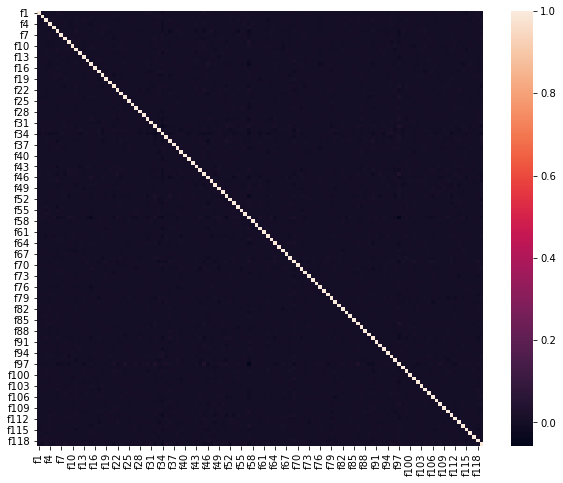

In [11]:
plot , ax = plt.subplots(figsize=(10,8))
sns.heatmap(train.corr())

### Number of groups
From the below plot, we can see there equal number of traget values present in the training data.so, our dataset is a balansed dataset.

<AxesSubplot:xlabel='claim', ylabel='count'>

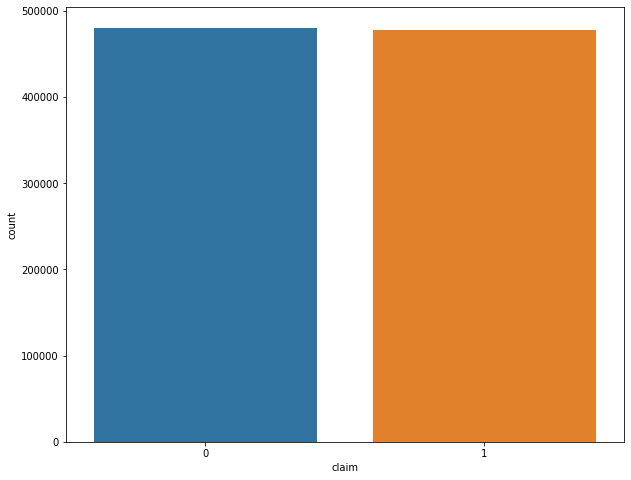

In [12]:
plot , ax = plt.subplots(figsize=(10,8))

sns.countplot(train['claim'])

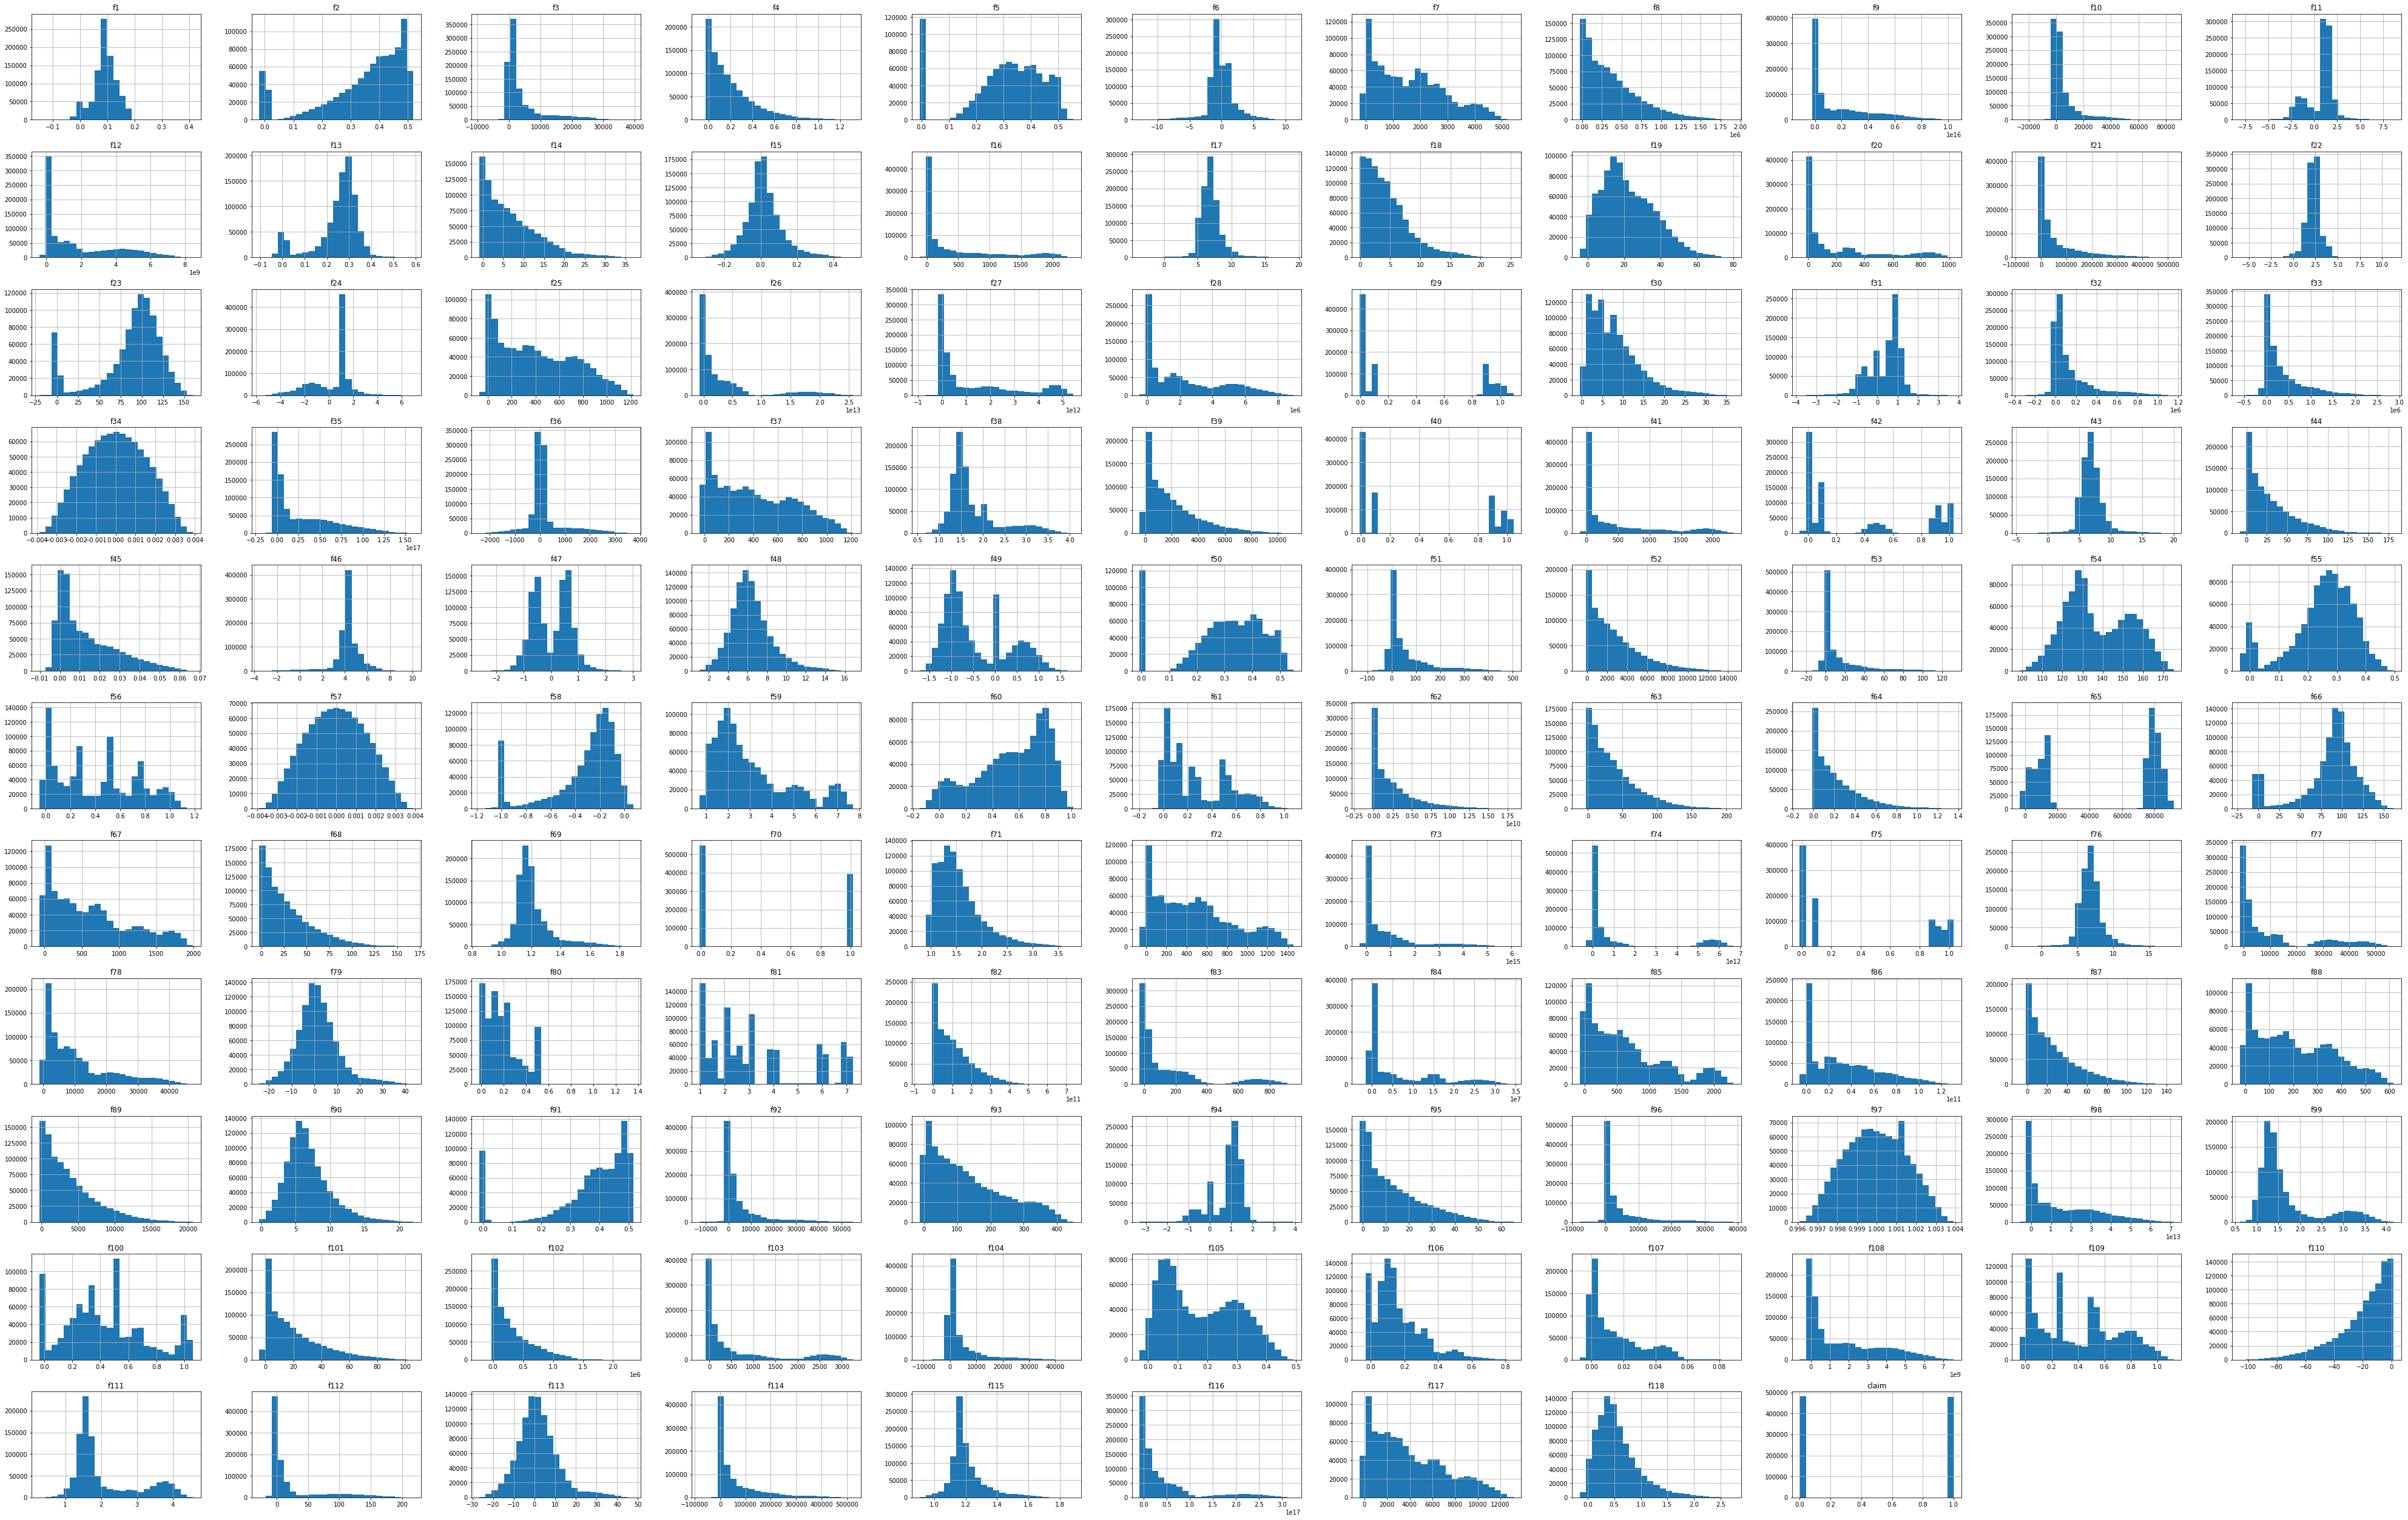

In [13]:

hist = train.hist(bins = 25, figsize=(70,45))

<a id="section_intro"></a>
# 4. Data Preprocessing
4.1. Handling Missing Values
4.2. Handling Categorical data
4.3. Handle imbalance dataset
4.4. Feature Reduction (next submission)
4.5. Standardization (or) Normalization

In [14]:
features = train.columns.tolist()[0:-1]
target = ['claim']

<a id="section_missingvalues"></a>
## 4.1. Handling Missing Values

In [15]:
train_row,train_col = train.shape
test_row, test_col = test.shape
#find the missing values w.r.t. column
train_colum_missing = train.isnull().sum()
train_total_missing = sum(train_colum_missing)
# find the missing values w.r.t. row(number of missing values in the particular row)
train_row_missing = train[features].isnull().sum(axis=1)

# add the missing values to row to the dataframe as a new value
train['no_of_missing_data'] = train_row_missing



#find the missing values w.r.t. column
test_colum_missing = test.isnull().sum()
test_total_missing=sum(test_colum_missing)
# find the missing values w.r.t. row(number of missing values in the particular row)
test_row_missing = test[features].isnull().sum(axis=1)

# add the missing values to row to the dataframe as a new value
test['no_of_missing_data'] = test_row_missing


In [16]:
print(f"Total number of missing values in training dataset---->{train_total_missing}")
print(f"Total number of missing values in testing dataset----->{test_total_missing}")
# compare this to the whole data
train_no_of_missing_rows = (train['no_of_missing_data'] != 0).sum()
print("\n{0:{fill}{align}80}\n".format("Training Data" , fill = "=", align = "^"))
print(f"Total rows -----------------------> {train_row}\nNumber of rows has missing data---> {train_no_of_missing_rows}\n{'-'*50}\nNumber of rows has full data--------> {train_row-train_no_of_missing_rows}")

test_no_of_missing_rows = (test['no_of_missing_data'] != 0).sum()
print("\n{0:{fill}{align}80}\n".format("Testing Data" , fill = "=", align = "^"))
print(f"Total rows -----------------------> {test_row}\nNumber of rows has missing data---> {test_no_of_missing_rows}\n{'-'*50}\nNumber of rows has full data--------> {test_row-test_no_of_missing_rows}")

Total number of missing values in training dataset---->1820782
Total number of missing values in testing dataset----->936218

=================================Training Data==================================

Total rows -----------------------> 957919
Number of rows has missing data---> 598455
--------------------------------------------------
Number of rows has full data--------> 359464

==================================Testing Data==================================

Total rows -----------------------> 493474
Number of rows has missing data---> 307781
--------------------------------------------------
Number of rows has full data--------> 185693


From this we can see , 2/3 of the dataset containing missing values both in training and testing data. we must need to handle this before going to model traning.<br/>
There are some methods to deal with missing values, we can see some methods in this separate notebook----->https://www.kaggle.com/ninjaac/methods-to-handle-missing-value

In [17]:
# here i am going to use the media for now.
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
train.iloc[:,0:-1]  = pd.DataFrame(imputer.fit_transform(train.iloc[:,0:-1]), columns = train.columns.tolist()[0:-1], index = train.index)
test = pd.DataFrame(imputer.transform(test),columns = test.columns, index = test.index)

<a id="section_categoricalData"></a>
## 4.2. Handling Categorical data 

This dataset has no categorical data, so we don't need to care about this for now. if want we can learn about the categorical values here -->https://www.kaggle.com/alexisbcook/categorical-variables

<a id="section_imbalance"></a>
## 4.3. Handle imbalance dataset

We can see the model having squal number of training and testing dataset, so here we don't need to balance the dataset. all fine....good to go next:)

<AxesSubplot:xlabel='claim', ylabel='count'>

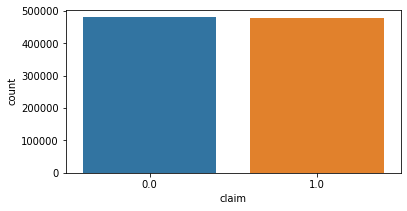

In [18]:
plot , ax = plt.subplots(figsize=(6,3))

sns.countplot(train['claim'])

<a id="section_scaling"></a>
## 4.5. Scaling

In [ ]:
# scaler = StandardScaler()
# train.iloc[:,0:-1] = pd.DataFrame(imputer.fit_transform(train.iloc[:,0:-1]), columns = train.columns.tolist()[0:-1], index = train.index)
# test = pd.DataFrame(imputer.transform(test), columns = test.columns, index = test.index)

<a id="section_feature"></a>
# 5. Feature Engineering

Adding some feature or reducing some feature by selcting the most important feature(Feature Selection) is called feature engineering.<br/>
Here we are going to add some features like min, max, mean, median, mode, standard diviation number of missing values in the row. i got this idea from my random learning from some code books of this compatition.

In [19]:
def feature_adding(data):
    data["min"] = data.min(axis = 1) # 1 or ‘columns’ : get mode of each row.
    data['max'] = data.max(axis = 1)
    data['std'] = data.std(axis = 1)
    data['median'] = data.median(axis = 1)
    data['mean'] = data.mean(axis = 1)
    #data['mode'] = data.mode(axis = 1)
    data['mad'] = data.mad(axis = 1) # mean absolute deviation
    data['skew'] = data.skew(axis=1)
     # no of missing data already added in the handling missing value section.
    # scale the data
    features = data.columns.tolist()
    scaler = StandardScaler()
    data[features] = pd.DataFrame(imputer.fit_transform(data[features]), columns = data.columns.tolist(), index = data.index)
    
    
    return data
    

In [20]:
train_y = train['claim'].copy()
train_X = feature_adding(train.drop('claim', axis = 1))
test = feature_adding(test)

In [21]:
del(train)

<a id="section_wo_hyper"></a>
## 6.1. Base model without hyperparameter tuning

<a id="section_xgboost"></a>
### 6.1.1. XGBoost

In [ ]:
xgb_params = {
    'max_depth': 2,
    'booster': 'gbtree', 
    'n_estimators': 10000,
    'random_state':42,
    'tree_method':'gpu_hist',
    'gpu_id':0,
    'predictor':"gpu_predictor",
}

In [ ]:
#Setting the kfold parameters
n_fold = 15
kf = KFold(n_splits = n_fold, shuffle = True, random_state = 42)
pred = 0
results = np.zeros((train_X.shape[0],))
mean_acc = 0

xgb_model = XGBClassifier(**xgb_params)


for fold, (train_id, valid_id) in enumerate(kf.split(train_X)):
    X_train, X_val = train_X.loc[train_id],train_X.loc[valid_id]
    y_train, y_val = train_y.iloc[train_id], train_y.iloc[valid_id]
    
    
    xgb_model.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = "auc",
             early_stopping_rounds = 100)
    
    
    #Out of Fold predictions
    results=  xgb_model.predict_proba(X_val) 
    
    pred += xgb_model.predict_proba(test)[:,1] / n_fold
    
    fold_acc = roc_auc_score(y_val ,results[:,1])
    
    print(f"Fold {fold} | Fold accuracy: {fold_acc}")
    
    mean_acc += fold_acc / n_fold
    
print(f"\nOverall Accuracy: {mean_acc}")

#### after feature engineeering 
score with default parameter and Standarscalar and median imputer =  0.8152311464421033 <br/>
score with default parameter and Normalization and constant zero imputer =  0.8153624191860824 <br/>
score with default parameter and Standarscalar and mean imputer =  0.8154707510791169 <br/>
mean is higher so talking that one.

<a id="section_log_reg"></a>
## 6.1.2. Logistic Regression

In [ ]:
#Setting the kfold parameters
n_fold = 5
kf = KFold(n_splits = n_fold, shuffle = True, random_state = 42)
pred = 0
results = np.zeros((train_X.shape[0],))
mean_acc = 0

log_reg = LogisticRegression(n_jobs = -1,C = 0.01, penalty = 'l2', random_state = 42)


for fold, (train_id, valid_id) in enumerate(kf.split(train_X)):
    X_train, X_val = train_X.loc[train_id], train_X.loc[valid_id]
    y_train, y_val = train_y.iloc[train_id], train_y.iloc[valid_id]
    
    
    log_reg.fit(X_train, y_train,
             )
    
    
    #Out of Fold predictions
    results=  log_reg.predict_proba(X_val) 
    
    pred += log_reg.predict_proba(test)[:,1] / n_fold
    
    fold_acc = roc_auc_score(y_val ,results[:,1])
    
    print(f"Fold {fold} | Fold accuracy: {fold_acc}")
    
    mean_acc += fold_acc / n_fold
    
print(f"\nOverall Accuracy: {mean_acc}")

# just trying path
score with default parameter and Standarscalar and median imputer = 0.5075950898769981 (so bad)<br/>
score with default parameter and Standarscalar and mean imputer = 0.5069218256005761 <br/>
score with default parameter and Standarscalar and constant zero imputer = 0.507425029718713 (so bad)<br/> 

#### Not a big difference
score with default parameter and Normalization and median imputer = 0.5056612627208464 (so bad)<br/>
score with default parameter and Normalization and mean imputer = 0.5056612627208464 <br/>
score with default parameter and Normalization and constant zero imputer = 0.5055436207845755(so bad)<br/> 

#### after feature engineeering ( i can't find any improvement after feature engneering)
score with default parameter and Standarscalar and median imputer = 0.5090028286920467 <br/>
score with default parameter and Normalization and constant zero imputer = 0.5125507184919263

<a id="section_hyper"></a>
# 6.2. Model with hyperparameter tuning using optuna

In [22]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, random_state=0, test_size = 0.1)



<a id="section_xgb_hyper"></a>
## 6.2.1. XGBoost

In [23]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 5000, 50000, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 100.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 100.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 100.0),
        
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
    }
    
    #XGBoost model fitting.
    xgb = XGBClassifier(**param, 
                         random_state=24,
                         tree_method='gpu_hist' , 
                         gpu_id = 0, 
                         predictor="gpu_predictor",)
    
    
    xgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = "auc",
             early_stopping_rounds = 100)
    
    # precdition .
    xgb_pred = xgb.predict_proba(X_val)
    
    acc = roc_auc_score(y_val, xgb_pred[:,1])
    return acc

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40) 

print("lenth of the finished trials: ", len(study.trials))


print("Best value for the rmse:", study.best_trial.value)
print("Best parameters:", study.best_params)

[I 2021-09-13 15:49:08,166] A new study created in memory with name: no-name-9a2ae2b8-dfdf-466f-9260-c97e4ec7ee20
[I 2021-09-13 15:51:59,342] Trial 0 finished with value: 0.8168589915396766 and parameters: {'n_estimators': 33500, 'max_depth': 8, 'min_child_weight': 34, 'subsample': 0.740539429264228, 'colsample_bytree': 0.744052756275191, 'gamma': 1.7718572012204396e-05, 'alpha': 1.8563104778710868e-08, 'lambda': 0.0007591618210616478, 'learning_rate': 0.007873622476939327}. Best is trial 0 with value: 0.8168589915396766.
[I 2021-09-13 15:54:55,162] Trial 1 finished with value: 0.8160919002448237 and parameters: {'n_estimators': 10500, 'max_depth': 7, 'min_child_weight': 41, 'subsample': 0.9294191108404493, 'colsample_bytree': 0.21124962876610887, 'gamma': 0.031048810909233303, 'alpha': 92.01280758962658, 'lambda': 0.5546082881615025, 'learning_rate': 0.01081483549412266}. Best is trial 0 with value: 0.8168589915396766.
[I 2021-09-13 15:59:41,939] Trial 2 finished with value: 0.8165675

lenth of the finished trials:  40
Best value for the rmse: 0.8168811032265727
Best parameters: {'n_estimators': 29000, 'max_depth': 3, 'min_child_weight': 66, 'subsample': 0.7842215931394566, 'colsample_bytree': 0.5179071234426729, 'gamma': 0.4700525265587939, 'alpha': 0.000257843578177255, 'lambda': 2.4671217994166645, 'learning_rate': 0.012418427180920295}


In [25]:
best_param = study.best_params
best_param

"""{'n_estimators': 29000,
 'max_depth': 3,
 'min_child_weight': 66,
 'subsample': 0.7842215931394566,
 'colsample_bytree': 0.5179071234426729,
 'gamma': 0.4700525265587939,
 'alpha': 0.000257843578177255,
 'lambda': 2.4671217994166645,
 'learning_rate': 0.012418427180920295}"""

{'n_estimators': 29000,
 'max_depth': 3,
 'min_child_weight': 66,
 'subsample': 0.7842215931394566,
 'colsample_bytree': 0.5179071234426729,
 'gamma': 0.4700525265587939,
 'alpha': 0.000257843578177255,
 'lambda': 2.4671217994166645,
 'learning_rate': 0.012418427180920295}

In [31]:
#Setting the kfold parameters
n_fold = 5
kf = KFold(n_splits = n_fold, shuffle = True, random_state = 42)
pred = 0
results = np.zeros((train_X.shape[0],))
mean_acc = 0

xgb_model = XGBClassifier(**best_param,               
      booster= 'gbtree', 
    random_state = 42,
    tree_method = 'gpu_hist',
    gpu_id= 0,
    predictor="gpu_predictor",)


for fold, (train_id, valid_id) in enumerate(kf.split(train_X)):
    X_train, X_val = train_X.loc[train_id],train_X.loc[valid_id]
    y_train, y_val = train_y.iloc[train_id], train_y.iloc[valid_id]
    
    
    xgb_model.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = "auc",
             early_stopping_rounds = 100)
    
    
    #Out of Fold predictions
    results=  xgb_model.predict_proba(X_val) 
    
    pred += xgb_model.predict_proba(test)[:,1] / n_fold
    
    fold_acc = roc_auc_score(y_val ,results[:,1])
    
    print(f"Fold {fold} | Fold accuracy: {fold_acc}")
    
    mean_acc += fold_acc / n_fold
    
print(f"\nOverall Accuracy: {mean_acc}")

Fold 0 | Fold accuracy: 0.8149925046623997
Fold 1 | Fold accuracy: 0.8168459110591458
Fold 2 | Fold accuracy: 0.8154265946994338
Fold 3 | Fold accuracy: 0.816044661304239
Fold 4 | Fold accuracy: 0.8171508099009345

Overall Accuracy: 0.8160920963252306


<a id="section_sub"></a>
## 6. Submision

In [32]:
sub = pd.read_csv("../input/tabular-playground-series-sep-2021/sample_solution.csv")

In [33]:
sub['claim'] = pred

In [34]:
sub.to_csv('submission3.csv',index=False)